# ML + DL Hybrid Fusion Ensemble
## Advanced Fraud Detection - Combining Machine Learning and Deep Learning

**Objective:** Create a powerful hybrid ensemble by fusing ML and DL models

**Fusion Strategies:**
1. **Voting Ensemble** (Hard & Soft)
2. **Weighted Averaging** (Performance-based weights)
3. **Stacking Ensemble** (Meta-learner)
4. **Custom Fusion** (Optimized combination)

**Expected Benefits:**
- Better generalization from combining different model types
- Reduced overfitting through ensemble diversity
- Higher F1-Score and ROC-AUC
- More robust fraud detection

---

## 1. Import Libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML & DL Libraries
import pickle
import joblib
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve, classification_report
)
from sklearn.calibration import CalibratedClassifierCV

# Utils
import os
import json
from datetime import datetime

print(" All libraries imported successfully!")

 All libraries imported successfully!


In [43]:
print("="*80)
print("HYBRID ML + DL FUSION ENSEMBLE")
print("="*80)
print()
print("This notebook demonstrates:")
print("1. Loading pre-trained ML models (5 models)")
print("2. Loading pre-trained DL models (6 tuned models)") 
print("3. Creating fusion ensemble with meta-learner")
print("4. Evaluating hybrid performance")
print("5. Saving final fusion model")
print()
print(" Base Models:")
print(" • ML Models: 5 (Logistic Regression, Random Forest, XGBoost, CatBoost, LightGBM)")
print(" • DL Models: 6 (FNN, CNN, LSTM, BiLSTM, Hybrid, Autoencoder)")
print(" • TOTAL: 11 base models")
print()
print(" Libraries imported successfully!")

HYBRID ML + DL FUSION ENSEMBLE

This notebook demonstrates:
1. Loading pre-trained ML models (5 models)
2. Loading pre-trained DL models (6 tuned models)
3. Creating fusion ensemble with meta-learner
4. Evaluating hybrid performance
5. Saving final fusion model

 Base Models:
 • ML Models: 5 (Logistic Regression, Random Forest, XGBoost, CatBoost, LightGBM)
 • DL Models: 6 (FNN, CNN, LSTM, BiLSTM, Hybrid, Autoencoder)
 • TOTAL: 11 base models

 Libraries imported successfully!


## 2. Load Datasets

In [44]:
print("="*80)
print("LOADING DATASETS FROM DL 72-FEATURES TRAINING")
print("="*80)

# Define data directory
data_dir = '../dl'

print("\nLoading data from DL 72-features training notebook...")
print("Note: Data is already split (60/20/20) and scaled in DL notebook")
print()

# Load the DL notebook's saved data
# These are the numpy arrays from dl_72features_training.ipynb after training
# We'll need to get: X_train, X_val, X_test, y_train, y_val, y_test (all scaled)

# For now, let's use the dataset directly
print(" Loading train_72_features.csv...")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('../../data/train_72_features.csv')
print(f" Original: {df.shape}")

df = df.drop_duplicates()
print(f" After removing duplicates: {df.shape}")

X = df.drop('isFraud', axis=1)
y = df['isFraud']

print(f"\n Splitting data: 60% train, 20% val, 20% test...")
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"\n Dataset split:")
print(f" Training: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f" Validation: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f" Test: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

print(f"\n Applying StandardScaler...")
scaler = StandardScaler()

# Keep unscaled versions for tree-based models
X_train_unscaled = X_train.copy()
X_val_unscaled = X_val.copy()
X_test_unscaled = X_test.copy()

# Create scaled versions for DL models and Logistic Regression
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

print(f" Scaler fitted and data normalized")

print(f"\n Class distribution (Validation set):")
print(f" Normal (0): {(y_val == 0).sum():,} ({(y_val == 0).sum() / len(y_val) * 100:.1f}%)")
print(f" Fraud (1): {(y_val == 1).sum():,} ({(y_val == 1).sum() / len(y_val) * 100:.1f}%)")

print("\n Datasets ready for model loading and fusion!")

LOADING DATASETS FROM DL 72-FEATURES TRAINING

Loading data from DL 72-features training notebook...
Note: Data is already split (60/20/20) and scaled in DL notebook

 Loading train_72_features.csv...
 Original: (590540, 72)
 Original: (590540, 72)
 After removing duplicates: (419227, 72)

 Splitting data: 60% train, 20% val, 20% test...
 After removing duplicates: (419227, 72)

 Splitting data: 60% train, 20% val, 20% test...

 Dataset split:
 Training: 251,535 samples (60.0%)
 Validation: 83,846 samples (20.0%)
 Test: 83,846 samples (20.0%)

 Applying StandardScaler...

 Dataset split:
 Training: 251,535 samples (60.0%)
 Validation: 83,846 samples (20.0%)
 Test: 83,846 samples (20.0%)

 Applying StandardScaler...
 Scaler fitted and data normalized

 Class distribution (Validation set):
 Normal (0): 80,340 (95.8%)
 Fraud (1): 3,506 (4.2%)

 Datasets ready for model loading and fusion!
 Scaler fitted and data normalized

 Class distribution (Validation set):
 Normal (0): 80,340 (95.8%)

## 3. Load Trained ML Models

In [45]:
print("="*80)
print("LOADING PRE-TRAINED ML MODELS (5 TUNED MODELS)")
print("="*80)

# Directory containing ML models
ml_models_dir = '../ml/models'

# List of ML model files (all tuned on 72 features)
ml_model_files = [
    ('Logistic Regression', 'logistic_regression_tuned_72features.pkl'),
    ('Random Forest', 'random_forest_tuned_72features.pkl'),
    ('XGBoost', 'xgboost_tuned_72features.pkl'),
    ('CatBoost', 'catboost_tuned_72features.pkl'),
    ('LightGBM', 'lightgbm_tuned_72features.pkl')
]

# Load ML models
ml_models = {}
print(f"\n Loading ML models from: {ml_models_dir}\n")

for model_name, filename in ml_model_files:
    try:
        model_path = os.path.join(ml_models_dir, filename)
        
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        
        ml_models[model_name] = model
        print(f" {model_name:25} -> {filename}")
        
    except FileNotFoundError:
        print(f"X {model_name:25} -> File not found: {filename}")
    except Exception as e:
        print(f"X {model_name:25} -> Error: {str(e)}")

print(f"\n Successfully loaded {len(ml_models)}/5 ML models")

# Display model types
print("\n Model Summary:")
for name, model in ml_models.items():
    print(f"  * {name}: {type(model).__name__}")

LOADING PRE-TRAINED ML MODELS (5 TUNED MODELS)

 Loading ML models from: ../ml/models

 Logistic Regression       -> logistic_regression_tuned_72features.pkl
 Random Forest             -> random_forest_tuned_72features.pkl
 Random Forest             -> random_forest_tuned_72features.pkl
 XGBoost                   -> xgboost_tuned_72features.pkl
 CatBoost                  -> catboost_tuned_72features.pkl
 LightGBM                  -> lightgbm_tuned_72features.pkl

 Successfully loaded 5/5 ML models

 Model Summary:
  * Logistic Regression: LogisticRegression
  * Random Forest: RandomForestClassifier
  * XGBoost: XGBClassifier
  * CatBoost: CatBoostClassifier
  * LightGBM: LGBMClassifier
 XGBoost                   -> xgboost_tuned_72features.pkl
 CatBoost                  -> catboost_tuned_72features.pkl
 LightGBM                  -> lightgbm_tuned_72features.pkl

 Successfully loaded 5/5 ML models

 Model Summary:
  * Logistic Regression: LogisticRegression
  * Random Forest: RandomFore

**Note:** Models are now loaded using `joblib` (matching the ML notebook save method). This resolves compatibility issues with Random Forest and Logistic Regression! 

## 4. Load Trained DL Models

In [46]:
print("\n" + "="*80)
print("LOADING DEEP LEARNING MODELS")
print("="*80)

dl_models_dir = '../dl/saved_models'
dl_models = {}

# List of DL models to load (all tuned .keras models from new training)
dl_model_files = [
    ('FNN', 'fnn_tuned.keras'),
    ('CNN', 'cnn_tuned.keras'),
    ('LSTM', 'lstm_tuned.keras'),
    ('BiLSTM', 'bilstm_tuned.keras'),
    ('Hybrid', 'hybrid_tuned.keras'),
    ('Autoencoder', 'autoencoder_tuned.keras')
]

print("\n Loading DL models...")
for model_name, filename in dl_model_files:
    filepath = os.path.join(dl_models_dir, filename)
    if os.path.exists(filepath):
        try:
            dl_models[model_name] = keras.models.load_model(filepath)
            print(f"  Loaded: {model_name}")
        except Exception as e:
            print(f"  Error loading {model_name}: {str(e)}")
    else:
        print(f"  Not found: {model_name}")

print(f"\n Successfully loaded {len(dl_models)}/6 DL models:")
for name in dl_models.keys():
    print(f"  * {name}")

# Verify models can make predictions
if dl_models:
    test_model = list(dl_models.values())[0]
    test_pred = test_model.predict(X_val_scaled[:5], verbose=0)
    print(f"\n Model verification: Sample predictions shape = {test_pred.shape}")
    print(" DL models loaded and verified successfully!")

print(f"\n{'='*80}")
print(f"TOTAL BASE MODELS LOADED: {len(ml_models) + len(dl_models)}")
print(f"  * ML Models: {len(ml_models)}")
print(f"  * DL Models: {len(dl_models)}")
print(f"{'='*80}")


LOADING DEEP LEARNING MODELS

 Loading DL models...


  Loaded: FNN
  Loaded: CNN
  Loaded: LSTM
  Loaded: LSTM
  Loaded: BiLSTM
  Loaded: BiLSTM
  Loaded: Hybrid
  Loaded: Autoencoder

 Successfully loaded 6/6 DL models:
  * FNN
  * CNN
  * LSTM
  * BiLSTM
  * Hybrid
  * Autoencoder
  Loaded: Hybrid
  Loaded: Autoencoder

 Successfully loaded 6/6 DL models:
  * FNN
  * CNN
  * LSTM
  * BiLSTM
  * Hybrid
  * Autoencoder

 Model verification: Sample predictions shape = (5, 1)
 DL models loaded and verified successfully!

TOTAL BASE MODELS LOADED: 11
  * ML Models: 5
  * DL Models: 6

 Model verification: Sample predictions shape = (5, 1)
 DL models loaded and verified successfully!

TOTAL BASE MODELS LOADED: 11
  * ML Models: 5
  * DL Models: 6


## 5. Generate Predictions from All Base Models

In [47]:
print("\n" + "="*80)
print("GENERATING PREDICTIONS FROM ALL BASE MODELS")
print("="*80)

print("\n Generating predictions for fusion dataset creation...")
print(f" Using validation set as fusion training: {X_val_scaled.shape}")
print(f" Using test set for final evaluation: {X_test_scaled.shape}")

# Initialize prediction dictionaries
fusion_train_predictions = {}
fusion_test_predictions = {}

# 1. Generate ML Model Predictions
print("\n Generating ML model predictions...")
for model_name, model in ml_models.items():
    print(f"  Processing: {model_name}")
    
    # For ML models, determine if they need scaled or unscaled data
    if model_name == 'Logistic Regression':
        # Logistic Regression needs scaled data
        val_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # Tree-based models (RF, XGB, CatBoost, LightGBM) prefer unscaled data
        val_pred_proba = model.predict_proba(X_val_unscaled)[:, 1]
        test_pred_proba = model.predict_proba(X_test_unscaled)[:, 1]
    
    # Store predictions
    fusion_train_predictions[f'{model_name}_pred'] = val_pred_proba
    fusion_test_predictions[f'{model_name}_pred'] = test_pred_proba
    
    print(f"    Prediction range: [{val_pred_proba.min():.4f}, {val_pred_proba.max():.4f}]")

# 2. Generate DL Model Predictions 
print("\n Generating DL model predictions...")
for model_name, model in dl_models.items():
    print(f"  Processing: {model_name}")
    
    if model_name == 'Autoencoder':
        # Special handling for Autoencoder: calculate reconstruction error
        val_reconstructed = model.predict(X_val_scaled, verbose=0)
        test_reconstructed = model.predict(X_test_scaled, verbose=0)
        
        # Calculate reconstruction error (Mean Squared Error per sample)
        val_pred_proba = np.mean((X_val_scaled.values - val_reconstructed) ** 2, axis=1)
        test_pred_proba = np.mean((X_test_scaled.values - test_reconstructed) ** 2, axis=1)
        
        # Normalize to [0,1] range (higher error = higher fraud probability)
        val_pred_proba = (val_pred_proba - val_pred_proba.min()) / (val_pred_proba.max() - val_pred_proba.min())
        test_pred_proba = (test_pred_proba - test_pred_proba.min()) / (test_pred_proba.max() - test_pred_proba.min())
        
    else:
        # Regular DL classification models use scaled data
        val_pred_proba = model.predict(X_val_scaled, verbose=0).ravel()
        test_pred_proba = model.predict(X_test_scaled, verbose=0).ravel()
    
    # Store predictions
    fusion_train_predictions[f'{model_name}_pred'] = val_pred_proba
    fusion_test_predictions[f'{model_name}_pred'] = test_pred_proba
    
    print(f"    Prediction range: [{val_pred_proba.min():.4f}, {val_pred_proba.max():.4f}]")

print(f"\n Summary:")
print(f"  * Total models: {len(fusion_train_predictions)}")
print(f"  * Fusion training samples: {len(y_val)}")
print(f"  * Fusion test samples: {len(y_test)}")
print(" All base model predictions generated successfully!")


GENERATING PREDICTIONS FROM ALL BASE MODELS

 Generating predictions for fusion dataset creation...
 Using validation set as fusion training: (83846, 71)
 Using test set for final evaluation: (83846, 71)

 Generating ML model predictions...
  Processing: Logistic Regression
    Prediction range: [0.0018, 1.0000]
  Processing: Random Forest
    Prediction range: [0.0032, 0.9999]
  Processing: XGBoost
    Prediction range: [0.0032, 0.9999]
  Processing: XGBoost
    Prediction range: [0.0000, 1.0000]
  Processing: CatBoost
    Prediction range: [0.0000, 1.0000]
  Processing: CatBoost
    Prediction range: [0.0000, 1.0000]
  Processing: LightGBM
    Prediction range: [0.0000, 1.0000]
  Processing: LightGBM
    Prediction range: [0.0000, 1.0000]

 Generating DL model predictions...
  Processing: FNN
    Prediction range: [0.0000, 1.0000]

 Generating DL model predictions...
  Processing: FNN
    Prediction range: [0.0010, 1.0000]
  Processing: CNN
    Prediction range: [0.0010, 1.0000]
  P

## 6. Create Fusion Dataset

In [48]:
# Debug: Check prediction shapes
print("\n Debugging prediction shapes...")
for key, pred in fusion_train_predictions.items():
    print(f"  {key}: {pred.shape}")

print(f"\ny_val shape: {y_val.shape}")

# Check for any NaN or infinite values
print("\n Checking for data quality issues...")
for key, pred in fusion_train_predictions.items():
    nan_count = np.isnan(pred).sum()
    inf_count = np.isinf(pred).sum()
    if nan_count > 0 or inf_count > 0:
        print(f"  ! {key}: {nan_count} NaNs, {inf_count} infinites")
    else:
        print(f"  {key}: Clean data")

print("Debug completed.")


 Debugging prediction shapes...
  Logistic Regression_pred: (83846,)
  Random Forest_pred: (83846,)
  XGBoost_pred: (83846,)
  CatBoost_pred: (83846,)
  LightGBM_pred: (83846,)
  FNN_pred: (83846,)
  CNN_pred: (83846,)
  LSTM_pred: (83846,)
  BiLSTM_pred: (83846,)
  Hybrid_pred: (83846,)
  Autoencoder_pred: (83846,)

y_val shape: (83846,)

 Checking for data quality issues...
  Logistic Regression_pred: Clean data
  Random Forest_pred: Clean data
  XGBoost_pred: Clean data
  CatBoost_pred: Clean data
  LightGBM_pred: Clean data
  FNN_pred: Clean data
  CNN_pred: Clean data
  LSTM_pred: Clean data
  BiLSTM_pred: Clean data
  Hybrid_pred: Clean data
  Autoencoder_pred: Clean data
Debug completed.


In [49]:
# Investigate the Autoencoder issue
print("\n Investigating Autoencoder model...")
autoencoder_model = dl_models['Autoencoder']
print(f"Autoencoder summary:")
autoencoder_model.summary()

# Check what the autoencoder actually outputs
sample_input = X_val_scaled[:5]
autoencoder_output = autoencoder_model.predict(sample_input, verbose=0)
print(f"\nSample input shape: {sample_input.shape}")
print(f"Autoencoder output shape: {autoencoder_output.shape}")
print(f"Sample output values: {autoencoder_output.flatten()[:10]}") # First 10 values


 Investigating Autoencoder model...
Autoencoder summary:


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder (Sequential)            │ (None, 16)             │         7,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ (None, 71)             │         7,271 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,463 (169.78 KB)

 Trainable params: 14,487 (56.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,976 (113.19 KB)


Sample input shape: (5, 71)
Autoencoder output shape: (5, 71)
Sample output values: [-0.34000814 -0.09897636 -0.6337434  -0.45943326 -0.10791369  0.43668592
 -0.19153923 -0.5874772  -0.12119822  0.05398151]


In [50]:
print("\n" + "="*80)
print("CREATING FUSION DATASETS")
print("="*80)

# Create fusion training dataset (using validation set)
print("\nCreating fusion training dataset...")
fusion_train_df = pd.DataFrame(fusion_train_predictions)
fusion_train_df['target'] = y_val.values

# Create fusion test dataset
print("Creating fusion test dataset...")
fusion_test_df = pd.DataFrame(fusion_test_predictions)
fusion_test_df['target'] = y_test.values

print(f"\nFusion datasets created:")
print(f"  Training: {fusion_train_df.shape} (11 model predictions + target)")
print(f"  Test: {fusion_test_df.shape} (11 model predictions + target)")

# Verify all prediction columns exist
print(f"\nAvailable prediction columns: {len(fusion_train_df.columns)-1}")
for col in fusion_train_df.columns:
    if col != 'target':
        print(f"  - {col}")


CREATING FUSION DATASETS

Creating fusion training dataset...
Creating fusion test dataset...

Fusion datasets created:
  Training: (83846, 12) (11 model predictions + target)
  Test: (83846, 12) (11 model predictions + target)

Available prediction columns: 11
  - Logistic Regression_pred
  - Random Forest_pred
  - XGBoost_pred
  - CatBoost_pred
  - LightGBM_pred
  - FNN_pred
  - CNN_pred
  - LSTM_pred
  - BiLSTM_pred
  - Hybrid_pred
  - Autoencoder_pred


## 7. Train Meta-Learner (Fusion Model)

In [51]:
# Prepare fusion datasets for meta-learner training
print("\n� Preparing fusion datasets for meta-learner...")

# Separate features and target
X_fusion_train = fusion_train_df.drop('target', axis=1)
y_fusion_train = fusion_train_df['target']

X_fusion_test = fusion_test_df.drop('target', axis=1)
y_fusion_test = fusion_test_df['target']

print(f" Training features: {X_fusion_train.shape}")
print(f" Training labels: {len(y_fusion_train)}")
print(f" Test features: {X_fusion_test.shape}")
print(f" Test labels: {len(y_fusion_test)}")

print(f"\n Class distribution:")
print(f" Training - Normal: {(y_fusion_train == 0).sum():,}, Fraud: {(y_fusion_train == 1).sum():,}")
print(f" Test - Normal: {(y_fusion_test == 0).sum():,}, Fraud: {(y_fusion_test == 1).sum():,}")


� Preparing fusion datasets for meta-learner...
 Training features: (83846, 11)
 Training labels: 83846
 Test features: (83846, 11)
 Test labels: 83846

 Class distribution:
 Training - Normal: 80,340, Fraud: 3,506
 Test - Normal: 80,340, Fraud: 3,506

 Training features: (83846, 11)
 Training labels: 83846
 Test features: (83846, 11)
 Test labels: 83846

 Class distribution:
 Training - Normal: 80,340, Fraud: 3,506
 Test - Normal: 80,340, Fraud: 3,506


In [52]:
print("\n" + "="*80)
print("TRAINING META-LEARNER (FUSION MODEL)")
print("="*80)

print("\n Training Logistic Regression meta-learner on fusion predictions...")
print(f" Training features: {X_fusion_train.shape}")
print(f" Training labels: {len(y_fusion_train)} samples")

# Define hyperparameter grid for meta-learner
print("\n Setting up hyperparameter grid...")
meta_param_grid = {
    'penalty': ['l2', 'none'],
    'C': [0.1, 0.5, 1.0, 2.0, 10.0],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['balanced', None],
    'max_iter': [1000, 2000]
}

print(f" Parameter combinations: {len(meta_param_grid['penalty']) * len(meta_param_grid['C']) * len(meta_param_grid['solver']) * len(meta_param_grid['class_weight']) * len(meta_param_grid['max_iter'])}")

# Set up GridSearchCV
print("\n Setting up GridSearchCV...")
base_meta_model = LogisticRegression(random_state=42)

meta_grid_search = GridSearchCV(
    estimator=base_meta_model,
    param_grid=meta_param_grid,
    scoring='f1_weighted',  # Focus on F1 score for imbalanced data
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

# Train meta-learner
print("\n Training meta-learner...")
print("This may take a few minutes...")
start_time = datetime.now()

meta_grid_search.fit(X_fusion_train, y_fusion_train)

end_time = datetime.now()
training_duration = (end_time - start_time).total_seconds()

print(f" Meta-learner training completed in {training_duration:.1f} seconds")

# Get best meta-model
meta_model = meta_grid_search.best_estimator_
print(f"\n Best meta-learner parameters:")
for param, value in meta_grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n Best cross-validation F1 score: {meta_grid_search.best_score_:.4f}")

# Make predictions on fusion training set to verify
meta_train_pred_proba = meta_model.predict_proba(X_fusion_train)[:, 1]
meta_train_pred = meta_model.predict(X_fusion_train)

# Calculate training metrics
train_accuracy = accuracy_score(y_fusion_train, meta_train_pred)
train_precision = precision_score(y_fusion_train, meta_train_pred)
train_recall = recall_score(y_fusion_train, meta_train_pred)
train_f1 = f1_score(y_fusion_train, meta_train_pred)
train_roc_auc = roc_auc_score(y_fusion_train, meta_train_pred_proba)

print(f"\n Meta-learner training performance:")
print(f"  Accuracy: {train_accuracy:.4f}")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall: {train_recall:.4f}")
print(f"  F1-Score: {train_f1:.4f}")
print(f"  ROC-AUC: {train_roc_auc:.4f}")

print("\n Meta-learner trained successfully!")


TRAINING META-LEARNER (FUSION MODEL)

 Training Logistic Regression meta-learner on fusion predictions...
 Training features: (83846, 11)
 Training labels: 83846 samples

 Setting up hyperparameter grid...
 Parameter combinations: 80

 Setting up GridSearchCV...

 Training meta-learner...
This may take a few minutes...
Fitting 5 folds for each of 80 candidates, totalling 400 fits

TRAINING META-LEARNER (FUSION MODEL)

 Training Logistic Regression meta-learner on fusion predictions...
 Training features: (83846, 11)
 Training labels: 83846 samples

 Setting up hyperparameter grid...
 Parameter combinations: 80

 Setting up GridSearchCV...

 Training meta-learner...
This may take a few minutes...
Fitting 5 folds for each of 80 candidates, totalling 400 fits
 Meta-learner training completed in 25.3 seconds

 Best meta-learner parameters:
  C: 10.0
  class_weight: None
  max_iter: 1000
  penalty: l2
  solver: liblinear

 Best cross-validation F1 score: 0.9958

 Meta-learner training perf

## 8. Optimize Decision Threshold

In [53]:
print("\n" + "="*80)
print("OPTIMIZING DECISION THRESHOLD")
print("="*80)

print("\n Finding optimal threshold for maximizing F1-score...")
print(" Testing thresholds from 0.1 to 0.9 with step 0.01")

# Generate probability predictions on fusion training set
fusion_train_proba = meta_model.predict_proba(X_fusion_train)[:, 1]

# Test different thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
threshold_results = []

print(f"\n⏳ Testing {len(thresholds)} thresholds...")
for threshold in thresholds:
    # Make binary predictions with current threshold
    y_pred_thresh = (fusion_train_proba >= threshold).astype(int)
 
    # Calculate metrics
    accuracy = accuracy_score(y_fusion_train, y_pred_thresh)
    precision = precision_score(y_fusion_train, y_pred_thresh, zero_division=0)
    recall = recall_score(y_fusion_train, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_fusion_train, y_pred_thresh, zero_division=0)
 
    threshold_results.append({
    'threshold': threshold,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
    })

# Convert to DataFrame for easier analysis
threshold_df = pd.DataFrame(threshold_results)

# Find best threshold based on F1-score
best_idx = threshold_df['f1_score'].idxmax()
best_threshold = threshold_df.loc[best_idx, 'threshold']
best_f1 = threshold_df.loc[best_idx, 'f1_score']
best_precision = threshold_df.loc[best_idx, 'precision']
best_recall = threshold_df.loc[best_idx, 'recall']
best_accuracy = threshold_df.loc[best_idx, 'accuracy']

print(f"\n� OPTIMAL THRESHOLD FOUND:")
print(f" Threshold: {best_threshold:.3f}")
print(f" F1-Score: {best_f1:.4f}")
print(f" Precision: {best_precision:.4f}")
print(f" Recall: {best_recall:.4f}") 
print(f" Accuracy: {best_accuracy:.4f}")

# Compare with default threshold (0.5)
default_pred = (fusion_train_proba >= 0.5).astype(int)
default_f1 = f1_score(y_fusion_train, default_pred)
default_precision = precision_score(y_fusion_train, default_pred, zero_division=0)
default_recall = recall_score(y_fusion_train, default_pred, zero_division=0)

print(f"\n Comparison with default threshold (0.5):")
print(f" Default F1-Score: {default_f1:.4f}")
print(f" Optimal F1-Score: {best_f1:.4f}")
print(f" F1-Score improvement: {((best_f1 - default_f1) / default_f1 * 100):+.2f}%")

# Save optimal threshold
threshold_config = {
    'best_threshold': float(best_threshold),
    'best_f1_score': float(best_f1),
    'best_precision': float(best_precision),
    'best_recall': float(best_recall),
    'best_accuracy': float(best_accuracy),
    'optimization_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('saved_models/best_threshold.json', 'w') as f:
    json.dump(threshold_config, f, indent=2)

print(f"\n Optimal threshold saved to: saved_models/best_threshold.json")
print(" Threshold optimization completed!")


OPTIMIZING DECISION THRESHOLD

 Finding optimal threshold for maximizing F1-score...
 Testing thresholds from 0.1 to 0.9 with step 0.01

⏳ Testing 80 thresholds...

� OPTIMAL THRESHOLD FOUND:
 Threshold: 0.530
 F1-Score: 0.9509
 Precision: 0.9406
 Recall: 0.9615
 Accuracy: 0.9958

 Comparison with default threshold (0.5):
 Default F1-Score: 0.9507
 Optimal F1-Score: 0.9509
 F1-Score improvement: +0.03%

 Optimal threshold saved to: saved_models/best_threshold.json
 Threshold optimization completed!

� OPTIMAL THRESHOLD FOUND:
 Threshold: 0.530
 F1-Score: 0.9509
 Precision: 0.9406
 Recall: 0.9615
 Accuracy: 0.9958

 Comparison with default threshold (0.5):
 Default F1-Score: 0.9507
 Optimal F1-Score: 0.9509
 F1-Score improvement: +0.03%

 Optimal threshold saved to: saved_models/best_threshold.json
 Threshold optimization completed!


## 9. Final Hybrid Model Evaluation

In [54]:
print("\n" + "="*80)
print("FINAL HYBRID MODEL EVALUATION")
print("="*80)

print("\n Testing hybrid fusion model on test set...")
print(f" Test set size: {X_fusion_test.shape}")

# Make predictions on test set
print("\n� Generating predictions...")
fusion_test_proba = meta_model.predict_proba(X_fusion_test)[:, 1]
fusion_test_pred_default = meta_model.predict(X_fusion_test) # Default threshold (0.5)
fusion_test_pred_optimal = (fusion_test_proba >= best_threshold).astype(int) # Optimal threshold

# Calculate comprehensive metrics
def calculate_metrics(y_true, y_pred, y_proba, threshold_name):
    """Calculate comprehensive metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
 
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
 
    return {
    'threshold': threshold_name,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc,
    'pr_auc': pr_auc,
    'specificity': specificity,
    'confusion_matrix': cm.tolist(),
    'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)
    }

# Evaluate with both thresholds
default_metrics = calculate_metrics(y_fusion_test, fusion_test_pred_default, fusion_test_proba, 'default_0.5')
optimal_metrics = calculate_metrics(y_fusion_test, fusion_test_pred_optimal, fusion_test_proba, f'optimal_{best_threshold:.3f}')

print(f"\n HYBRID MODEL TEST RESULTS:")
print(f"{'Metric':<15} {'Default (0.5)':<15} {'Optimal ({:.3f})':<15} {'Improvement':<15}".format(best_threshold))
print("-" * 75)

metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'pr_auc', 'specificity']
for metric in metrics_to_compare:
    default_val = default_metrics[metric]
    optimal_val = optimal_metrics[metric]
    improvement = ((optimal_val - default_val) / default_val * 100) if default_val > 0 else 0
 
    print(f"{metric.replace('_', ' ').title():<15} {default_val:<15.4f} {optimal_val:<15.4f} {improvement:+.2f}%")

# Detailed confusion matrices
print(f"\n CONFUSION MATRICES:")
print(f"\nDefault Threshold (0.5):")
print(f" True Neg: {default_metrics['tn']:,}")
print(f" False Pos: {default_metrics['fp']:,}")
print(f" False Neg: {default_metrics['fn']:,}")
print(f" True Pos: {default_metrics['tp']:,}")

print(f"\nOptimal Threshold ({best_threshold:.3f}):")
print(f" True Neg: {optimal_metrics['tn']:,}")
print(f" False Pos: {optimal_metrics['fp']:,}")
print(f" False Neg: {optimal_metrics['fn']:,}")
print(f" True Pos: {optimal_metrics['tp']:,}")

# Save results
final_results = {
    'model_info': {
    'model_type': 'Hybrid ML+DL Fusion Ensemble',
    'base_models': list(ml_models.keys()) + list(dl_models.keys()),
    'meta_learner': 'Logistic Regression',
    'total_base_models': len(ml_models) + len(dl_models),
    'evaluation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    },
    'test_results': {
    'default_threshold': default_metrics,
    'optimal_threshold': optimal_metrics
    }
}

# Save detailed results
with open('results/hybrid_model_metrics.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print(f"\n Results saved to: results/hybrid_model_metrics.json")

# Save predictions for further analysis
fusion_predictions_df = pd.DataFrame({
    'actual': y_fusion_test,
    'probability': fusion_test_proba,
    'prediction_default': fusion_test_pred_default,
    'prediction_optimal': fusion_test_pred_optimal
})
fusion_predictions_df.to_csv('results/fusion_predictions.csv', index=False)
print(f" Predictions saved to: results/fusion_predictions.csv")

print("\n Final hybrid model evaluation completed!")


FINAL HYBRID MODEL EVALUATION

 Testing hybrid fusion model on test set...
 Test set size: (83846, 11)

� Generating predictions...

 HYBRID MODEL TEST RESULTS:
Metric          Default (0.5)   Optimal (0.530) Improvement    
---------------------------------------------------------------------------
Accuracy        0.9741          0.9742          +0.01%
Precision       0.7775          0.7817          +0.54%
Recall          0.5334          0.5302          -0.59%
F1 Score        0.6327          0.6319          -0.13%
Roc Auc         0.8721          0.8721          +0.00%
Pr Auc          0.6607          0.6607          +0.00%
Specificity     0.9933          0.9935          +0.02%

 CONFUSION MATRICES:

Default Threshold (0.5):
 True Neg: 79,805
 False Pos: 535
 False Neg: 1,636
 True Pos: 1,870

Optimal Threshold (0.530):
 True Neg: 79,821
 False Pos: 519
 False Neg: 1,647
 True Pos: 1,859

 Results saved to: results/hybrid_model_metrics.json
 Predictions saved to: results/fusion_predict

## 10. Save Final Hybrid Pipeline

In [55]:
print("\n" + "="*80)
print("SAVING FINAL HYBRID PIPELINE")
print("="*80)

print("\n Saving trained models and configurations...")

# 1. Save meta-learner model
print(" Saving meta-learner model...")
joblib.dump(meta_model, 'saved_models/meta_model.pkl')
print("   Saved: saved_models/meta_model.pkl")

# 2. Save calibrated model for better probability outputs
print("\n Training and saving calibrated model...")
calibrated_model = CalibratedClassifierCV(meta_model, cv=5)
calibrated_model.fit(X_fusion_train, y_fusion_train)
joblib.dump(calibrated_model, 'saved_models/fusion_calibrator.pkl')
print("   Saved: saved_models/fusion_calibrator.pkl")

# 3. Best threshold is already saved
print("   Already saved: saved_models/best_threshold.json")

# 4. Create deployment configuration
deployment_config = {
    "model_info": {
        "type": "Hybrid ML+DL Fusion Ensemble",
        "version": "1.0",
        "created_date": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        "description": "Combines 5 ML models and 6 DL models using meta-learner"
    },
    "base_models": {
        "ml_models": {
            "count": len(ml_models),
            "models": list(ml_models.keys()),
            "data_type": "scaled for LR, unscaled for tree-based"
        },
        "dl_models": {
            "count": len(dl_models),
            "models": list(dl_models.keys()),
            "data_type": "scaled (StandardScaler)",
            "special_handling": {
                "Autoencoder": "Uses reconstruction error as anomaly score"
            }
        }
    },
    "meta_learner": {
        "algorithm": "Logistic Regression",
        "best_params": meta_grid_search.best_params_,
        "cv_f1_score": float(meta_grid_search.best_score_)
    },
    "performance": {
        "optimal_threshold": float(best_threshold),
        "test_f1_score": float(optimal_metrics['f1_score']),
        "test_roc_auc": float(optimal_metrics['roc_auc']),
        "test_precision": float(optimal_metrics['precision']),
        "test_recall": float(optimal_metrics['recall'])
    },
    "deployment_files": [
        "meta_model.pkl",
        "fusion_calibrator.pkl", 
        "best_threshold.json",
        "deployment_config.json"
    ]
}

with open('saved_models/deployment_config.json', 'w') as f:
    json.dump(deployment_config, f, indent=2)
print("   Saved: saved_models/deployment_config.json")

# 5. List all saved files
print(f"\n HYBRID MODEL FILES READY FOR DEPLOYMENT:")
saved_files = [
    'saved_models/meta_model.pkl',
    'saved_models/fusion_calibrator.pkl',
    'saved_models/best_threshold.json',
    'saved_models/deployment_config.json',
    'results/fusion_train.csv',
    'results/fusion_test.csv',
    'results/hybrid_model_metrics.json',
    'results/fusion_predictions.csv'
]

for file_path in saved_files:
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"   {file_path} ({file_size:.1f} KB)")
    else:
        print(f"   {file_path} (missing)")

print(f"\n HYBRID FUSION MODEL SUMMARY:")
print(f"   Base Models: {len(ml_models)} ML + {len(dl_models)} DL = {len(ml_models) + len(dl_models)} total")
print(f"   Meta-learner: Logistic Regression")
print(f"   Optimal Threshold: {best_threshold:.3f}")
print(f"   Test F1-Score: {optimal_metrics['f1_score']:.4f}")
print(f"   Test ROC-AUC: {optimal_metrics['roc_auc']:.4f}")
print(f"   Test Precision: {optimal_metrics['precision']:.4f}")
print(f"   Test Recall: {optimal_metrics['recall']:.4f}")

print("\n HYBRID FUSION PIPELINE COMPLETED SUCCESSFULLY!")
print("   Ready for API deployment and production use!")



SAVING FINAL HYBRID PIPELINE

 Saving trained models and configurations...
 Saving meta-learner model...
   Saved: saved_models/meta_model.pkl

 Training and saving calibrated model...
   Saved: saved_models/fusion_calibrator.pkl
   Already saved: saved_models/best_threshold.json
   Saved: saved_models/deployment_config.json

 HYBRID MODEL FILES READY FOR DEPLOYMENT:
   saved_models/meta_model.pkl (1.4 KB)
   saved_models/fusion_calibrator.pkl (6.8 KB)
   saved_models/best_threshold.json (0.2 KB)
   saved_models/deployment_config.json (1.4 KB)
   results/fusion_train.csv (2115.2 KB)
   results/fusion_test.csv (2115.9 KB)
   results/hybrid_model_metrics.json (1.6 KB)
   results/fusion_predictions.csv (2384.6 KB)

 HYBRID FUSION MODEL SUMMARY:
   Base Models: 5 ML + 6 DL = 11 total
   Meta-learner: Logistic Regression
   Optimal Threshold: 0.530
   Test F1-Score: 0.6319
   Test ROC-AUC: 0.8721
   Test Precision: 0.7817
   Test Recall: 0.5302

 HYBRID FUSION PIPELINE COMPLETED SUCCESSFUL

## 5. Helper Functions

In [59]:
def evaluate_model(y_true, y_pred_proba, y_pred, model_name, threshold=0.5):
    """
    Comprehensive model evaluation
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {model_name}")
    print(f"{'='*80}")
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Print results
    print(f"\nPerformance Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  PR-AUC: {pr_auc:.4f}")
    print(f"  Specificity: {specificity:.4f}")
    
    print(f"\nConfusion Matrix:")
    print(f"  TN: {tn:,} | FP: {fp:,}")
    print(f"  FN: {fn:,} | TP: {tp:,}")
    
    # Return metrics
    return {
        'model_name': model_name,
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc),
        'pr_auc': float(pr_auc),
        'specificity': float(specificity),
        'threshold': float(threshold),
        'confusion_matrix': cm.tolist(),
        'tp': int(tp),
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn)
    }


def get_ml_predictions(models, X, return_proba=True):
    """
    Get predictions from ML models
    """
    predictions = {}
    for name, model in models.items():
        if return_proba:
            # Get probability for fraud class (class 1)
            if hasattr(model, 'predict_proba'):
                predictions[name] = model.predict_proba(X)[:, 1]
            else:
                predictions[name] = model.predict(X)
        else:
            predictions[name] = model.predict(X)
    return predictions


def get_dl_predictions(models, X, return_proba=True):
    """
    Get predictions from DL models
    """
    predictions = {}
    
    # Prepare input data
    X_flat = X.values if isinstance(X, pd.DataFrame) else X
    
    for name, model in models.items():
        # Special handling for Autoencoder
        if name == "Autoencoder":
            reconstructed = model.predict(X_flat, verbose=0)
            reconstruction_error = np.mean((X_flat - reconstructed) ** 2, axis=1)
            proba = (reconstruction_error - reconstruction_error.min()) / (reconstruction_error.max() - reconstruction_error.min())
        else:
            # Choose appropriate input shape based on model type
            if "CNN" in name or "LSTM" in name or "BiLSTM" in name or "Hybrid" in name:
                X_input = X_flat.reshape(X_flat.shape[0], X_flat.shape[1], 1)
            else:
                X_input = X_flat
            
            # Get predictions and ensure 1D array
            pred_output = model.predict(X_input, verbose=0)
            proba = pred_output.ravel()  # Use ravel() instead of flatten()
        
        if return_proba:
            predictions[name] = proba
        else:
            predictions[name] = (proba > 0.5).astype(int)
    
    return predictions


print("Helper functions defined")

Helper functions defined


## 6. Baseline Performance - Individual Models

In [60]:
print("\n" + "="*80)
print("BASELINE PERFORMANCE - INDIVIDUAL MODELS")
print("="*80)

baseline_metrics = []

# Evaluate ML models
print("\n" + "-"*80)
print("MACHINE LEARNING MODELS")
print("-"*80)

ml_predictions_proba = get_ml_predictions(ml_models, X_val, return_proba=True)

for name, proba in ml_predictions_proba.items():
    pred = (proba > 0.5).astype(int)
    metrics = evaluate_model(y_val, proba, pred, f"ML: {name}")
    baseline_metrics.append(metrics)

# Evaluate DL models
print("\n" + "-"*80)
print("DEEP LEARNING MODELS")
print("-"*80)

# Convert to numpy array for DL models (they need numpy arrays, not DataFrames)
dl_predictions_proba = get_dl_predictions(dl_models, X_val_scaled.values, return_proba=True)

for name, proba in dl_predictions_proba.items():
    pred = (proba > 0.5).astype(int)
    metrics = evaluate_model(y_val, proba, pred, f"DL: {name}")
    baseline_metrics.append(metrics)

# Create comparison dataframe
baseline_df = pd.DataFrame(baseline_metrics)
baseline_df = baseline_df.sort_values('f1_score', ascending=False)

print("\n" + "="*80)
print("BASELINE RANKINGS (by F1-Score)")
print("="*80)
print("\n")
print(baseline_df[['model_name', 'f1_score', 'precision', 'recall', 'roc_auc', 'pr_auc']].to_string(index=False))


BASELINE PERFORMANCE - INDIVIDUAL MODELS

--------------------------------------------------------------------------------
MACHINE LEARNING MODELS
--------------------------------------------------------------------------------

EVALUATING: ML: Logistic Regression

Performance Metrics:
  Accuracy: 0.2402
  Precision: 0.0409
  Recall: 0.7653
  F1-Score: 0.0777
  ROC-AUC: 0.4911
  PR-AUC: 0.0411
  Specificity: 0.2173

Confusion Matrix:
  TN: 17,460 | FP: 62,880
  FN: 823 | TP: 2,683

EVALUATING: ML: Random Forest

Performance Metrics:
  Accuracy: 0.9744
  Precision: 0.7418
  Recall: 0.5950
  F1-Score: 0.6603
  ROC-AUC: 0.9374
  PR-AUC: 0.7071
  Specificity: 0.9910

Confusion Matrix:
  TN: 79,614 | FP: 726
  FN: 1,420 | TP: 2,086

EVALUATING: ML: XGBoost

Performance Metrics:
  Accuracy: 0.9854
  Precision: 0.7419
  Recall: 1.0000
  F1-Score: 0.8518
  ROC-AUC: 0.9996
  PR-AUC: 0.9898
  Specificity: 0.9848

Confusion Matrix:
  TN: 79,120 | FP: 1,220
  FN: 0 | TP: 3,506

EVALUATING: ML: Ca

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

---
## 7. Fusion Strategy 1: Simple Averaging

In [ ]:
print("\n" + "="*80)
print("FUSION STRATEGY 1: SIMPLE AVERAGING")
print("="*80)

# Combine all predictions
all_predictions_proba = {**ml_predictions_proba, **dl_predictions_proba}

# Simple average of all model probabilities
avg_proba = np.mean(list(all_predictions_proba.values()), axis=0)
avg_pred = (avg_proba > 0.5).astype(int)

# Evaluate
fusion_avg_metrics = evaluate_model(y_val, avg_proba, avg_pred, "Fusion: Simple Averaging (All Models)")

print(f"\n Simple Averaging uses {len(all_predictions_proba)} models")


FUSION STRATEGY 1: SIMPLE AVERAGING

EVALUATING: Fusion: Simple Averaging (All Models)

Performance Metrics:
 Accuracy: 0.8993
 Precision: 0.6787
 Recall: 0.4497
 F1-Score: 0.5410
 ROC-AUC: 0.8218
 PR-AUC: 0.5928
 Specificity: 0.9676

Confusion Matrix:
 TN: 10,132 | FP: 339
 FN: 876 | TP: 716

 Simple Averaging uses 10 models


## 8. Fusion Strategy 2: Weighted Averaging (Performance-Based)

In [ ]:
print("\n" + "="*80)
print("FUSION STRATEGY 2: WEIGHTED AVERAGING (F1-Score Based)")
print("="*80)

# Calculate weights based on F1-scores
weights = {}
total_f1 = 0

print("\nModel Weights (based on F1-Score):")
for metric in baseline_metrics:
    model_key = metric['model_name'].replace('ML: ', '').replace('DL: ', '')
    f1 = metric['f1_score']
    weights[model_key] = f1
    total_f1 += f1
    print(f" {model_key:25s}: {f1:.4f}")

# Normalize weights
for key in weights:
    weights[key] = weights[key] / total_f1

print("\nNormalized Weights:")
for key, weight in weights.items():
    print(f" {key:25s}: {weight:.4f}")

# Weighted average
weighted_proba = np.zeros(len(y_val))
for name, proba in all_predictions_proba.items():
    model_key = name
    if model_key in weights:
    weighted_proba += proba * weights[model_key]

weighted_pred = (weighted_proba > 0.5).astype(int)

# Evaluate
fusion_weighted_metrics = evaluate_model(y_val, weighted_proba, weighted_pred, "Fusion: Weighted Averaging (F1-Based)")


FUSION STRATEGY 2: WEIGHTED AVERAGING (F1-Score Based)

Model Weights (based on F1-Score):
 Logistic Regression : 0.4800
 Random Forest : 0.0967
 XGBoost : 0.0760
 XGBoost SMOTE : 0.2364
 CatBoost : 0.0382
 FNN : 0.5876
 CNN : 0.4851
 LSTM : 0.4276
 BiLSTM : 0.4120
 CNN-BiLSTM : 0.4223

Normalized Weights:
 Logistic Regression : 0.1472
 Random Forest : 0.0296
 XGBoost : 0.0233
 XGBoost SMOTE : 0.0725
 CatBoost : 0.0117
 FNN : 0.1801
 CNN : 0.1487
 LSTM : 0.1311
 BiLSTM : 0.1263
 CNN-BiLSTM : 0.1295

EVALUATING: Fusion: Weighted Averaging (F1-Based)

Performance Metrics:
 Accuracy: 0.8673
 Precision: 0.4977
 Recall: 0.6143
 F1-Score: 0.5499
 ROC-AUC: 0.8348
 PR-AUC: 0.6154
 Specificity: 0.9057

Confusion Matrix:
 TN: 9,484 | FP: 987
 FN: 614 | TP: 978


## 9. Fusion Strategy 3: Majority Voting

In [ ]:
print("\n" + "="*80)
print("FUSION STRATEGY 3: MAJORITY VOTING")
print("="*80)

# Get binary predictions from all models
all_binary_predictions = []
for proba in all_predictions_proba.values():
    all_binary_predictions.append((proba > 0.5).astype(int))

# Stack predictions
predictions_stack = np.vstack(all_binary_predictions)

# Majority vote
voting_pred = np.round(np.mean(predictions_stack, axis=0)).astype(int)

# For voting, we'll use the average probability as the "score"
voting_proba = avg_proba

# Evaluate
fusion_voting_metrics = evaluate_model(y_val, voting_proba, voting_pred, "Fusion: Majority Voting")

print(f"\n Majority Voting uses {len(all_predictions_proba)} models")


FUSION STRATEGY 3: MAJORITY VOTING

EVALUATING: Fusion: Majority Voting

Performance Metrics:
 Accuracy: 0.8902
 Precision: 0.6081
 Recall: 0.4717
 F1-Score: 0.5313
 ROC-AUC: 0.8218
 PR-AUC: 0.5928
 Specificity: 0.9538

Confusion Matrix:
 TN: 9,987 | FP: 484
 FN: 841 | TP: 751

 Majority Voting uses 10 models


## 10. Fusion Strategy 4: Top-K Best Models

In [ ]:
print("\n" + "="*80)
print("FUSION STRATEGY 4: TOP-K BEST MODELS")
print("="*80)

# Select top K models by F1-score
K = 5

top_k_models = baseline_df.nlargest(K, 'f1_score')['model_name'].tolist()

print(f"\nTop {K} models selected:")
for i, model in enumerate(top_k_models, 1):
    f1 = baseline_df[baseline_df['model_name'] == model]['f1_score'].values[0]
    print(f" {i}. {model:40s} (F1: {f1:.4f})")

# Get predictions from top K models only
topk_predictions = []
for name, proba in all_predictions_proba.items():
    full_name_ml = f"ML: {name}"
    full_name_dl = f"DL: {name}"
    if full_name_ml in top_k_models or full_name_dl in top_k_models:
    topk_predictions.append(proba)

# Average of top K
topk_proba = np.mean(topk_predictions, axis=0)
topk_pred = (topk_proba > 0.5).astype(int)

# Evaluate
fusion_topk_metrics = evaluate_model(y_val, topk_proba, topk_pred, f"Fusion: Top-{K} Models Averaging")


FUSION STRATEGY 4: TOP-K BEST MODELS

Top 5 models selected:
 1. DL: FNN (F1: 0.5876)
 2. DL: CNN (F1: 0.4851)
 3. ML: Logistic Regression (F1: 0.4800)
 4. DL: LSTM (F1: 0.4276)
 5. DL: CNN-BiLSTM (F1: 0.4223)

EVALUATING: Fusion: Top-5 Models Averaging

Performance Metrics:
 Accuracy: 0.8671
 Precision: 0.4972
 Recall: 0.6162
 F1-Score: 0.5504
 ROC-AUC: 0.8372
 PR-AUC: 0.6182
 Specificity: 0.9053

Confusion Matrix:
 TN: 9,479 | FP: 992
 FN: 611 | TP: 981


## 11. Fusion Strategy 5: Stacking with Meta-Learner

In [ ]:
print("\n" + "="*80)
print("FUSION STRATEGY 5: STACKING WITH META-LEARNER")
print("="*80)

# Create feature matrix from all model predictions
stacking_features = np.column_stack(list(all_predictions_proba.values()))

print(f"\nStacking features shape: {stacking_features.shape}")
print(f" {stacking_features.shape[1]} base models as features")
print(f" {stacking_features.shape[0]} samples")

# Train meta-learner (Logistic Regression)
print("\nTraining meta-learner (Logistic Regression)...")
meta_learner = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
meta_learner.fit(stacking_features, y_val)

print(" Meta-learner trained successfully")

# Get predictions
stacking_proba = meta_learner.predict_proba(stacking_features)[:, 1]
stacking_pred = meta_learner.predict(stacking_features)

# Evaluate
fusion_stacking_metrics = evaluate_model(y_val, stacking_proba, stacking_pred, "Fusion: Stacking (Logistic Meta-Learner)")

# Show feature importance (meta-learner coefficients)
print("\nMeta-Learner Feature Importance (Coefficients):")
feature_importance = pd.DataFrame({
    'Model': list(all_predictions_proba.keys()),
    'Coefficient': meta_learner.coef_[0]
}).sort_values('Coefficient', ascending=False)

print(feature_importance.to_string(index=False))


FUSION STRATEGY 5: STACKING WITH META-LEARNER

Stacking features shape: (12063, 10)
 10 base models as features
 12063 samples

Training meta-learner (Logistic Regression)...
 Meta-learner trained successfully

EVALUATING: Fusion: Stacking (Logistic Meta-Learner)

Performance Metrics:
 Accuracy: 0.8427
 Precision: 0.4401
 Recall: 0.7035
 F1-Score: 0.5415
 ROC-AUC: 0.8669
 PR-AUC: 0.6729
 Specificity: 0.8639

Confusion Matrix:
 TN: 9,046 | FP: 1,425
 FN: 472 | TP: 1,120

Meta-Learner Feature Importance (Coefficients):
 Model Coefficient
 FNN 5.025972
 Random Forest 1.795492
 XGBoost 1.118713
 CatBoost 1.053614
 CNN-BiLSTM 0.810779
Logistic Regression 0.296582
 BiLSTM 0.258249
 XGBoost SMOTE 0.027954
 CNN -0.250304
 LSTM -0.636252


---
## 12. Compare All Fusion Strategies

In [ ]:
print("\n" + "="*80)
print("FUSION STRATEGIES COMPARISON")
print("="*80)

# Collect all fusion metrics
fusion_metrics = [
    fusion_avg_metrics,
    fusion_weighted_metrics,
    fusion_voting_metrics,
    fusion_topk_metrics,
    fusion_stacking_metrics
]

# Create comparison dataframe
fusion_df = pd.DataFrame(fusion_metrics)
fusion_df = fusion_df.sort_values('f1_score', ascending=False)

print("\n")
print(fusion_df[['model_name', 'f1_score', 'precision', 'recall', 'roc_auc', 'pr_auc']].to_string(index=False))

# Find best fusion strategy
best_fusion = fusion_df.iloc[0]
print(f"\n" + "="*80)
print(f"BEST FUSION STRATEGY: {best_fusion['model_name']}")
print("="*80)
print(f"F1-Score: {best_fusion['f1_score']:.4f}")
print(f"Precision: {best_fusion['precision']:.4f}")
print(f"Recall: {best_fusion['recall']:.4f}")
print(f"ROC-AUC: {best_fusion['roc_auc']:.4f}")
print(f"PR-AUC: {best_fusion['pr_auc']:.4f}")


FUSION STRATEGIES COMPARISON


 model_name f1_score precision recall roc_auc pr_auc
 Fusion: Top-5 Models Averaging 0.550351 0.497212 0.616206 0.837237 0.618159
 Fusion: Weighted Averaging (F1-Based) 0.549902 0.497710 0.614322 0.834751 0.615446
Fusion: Stacking (Logistic Meta-Learner) 0.541455 0.440079 0.703518 0.866910 0.672928
 Fusion: Simple Averaging (All Models) 0.540990 0.678673 0.449749 0.821809 0.592820
 Fusion: Majority Voting 0.531305 0.608097 0.471734 0.821809 0.592820

BEST FUSION STRATEGY: Fusion: Top-5 Models Averaging
F1-Score: 0.5504
Precision: 0.4972
Recall: 0.6162
ROC-AUC: 0.8372
PR-AUC: 0.6182


## 13. Visualization - Fusion Performance


Creating fusion comparison visualizations...
Chart saved: hybrid_fusion_comparison.png


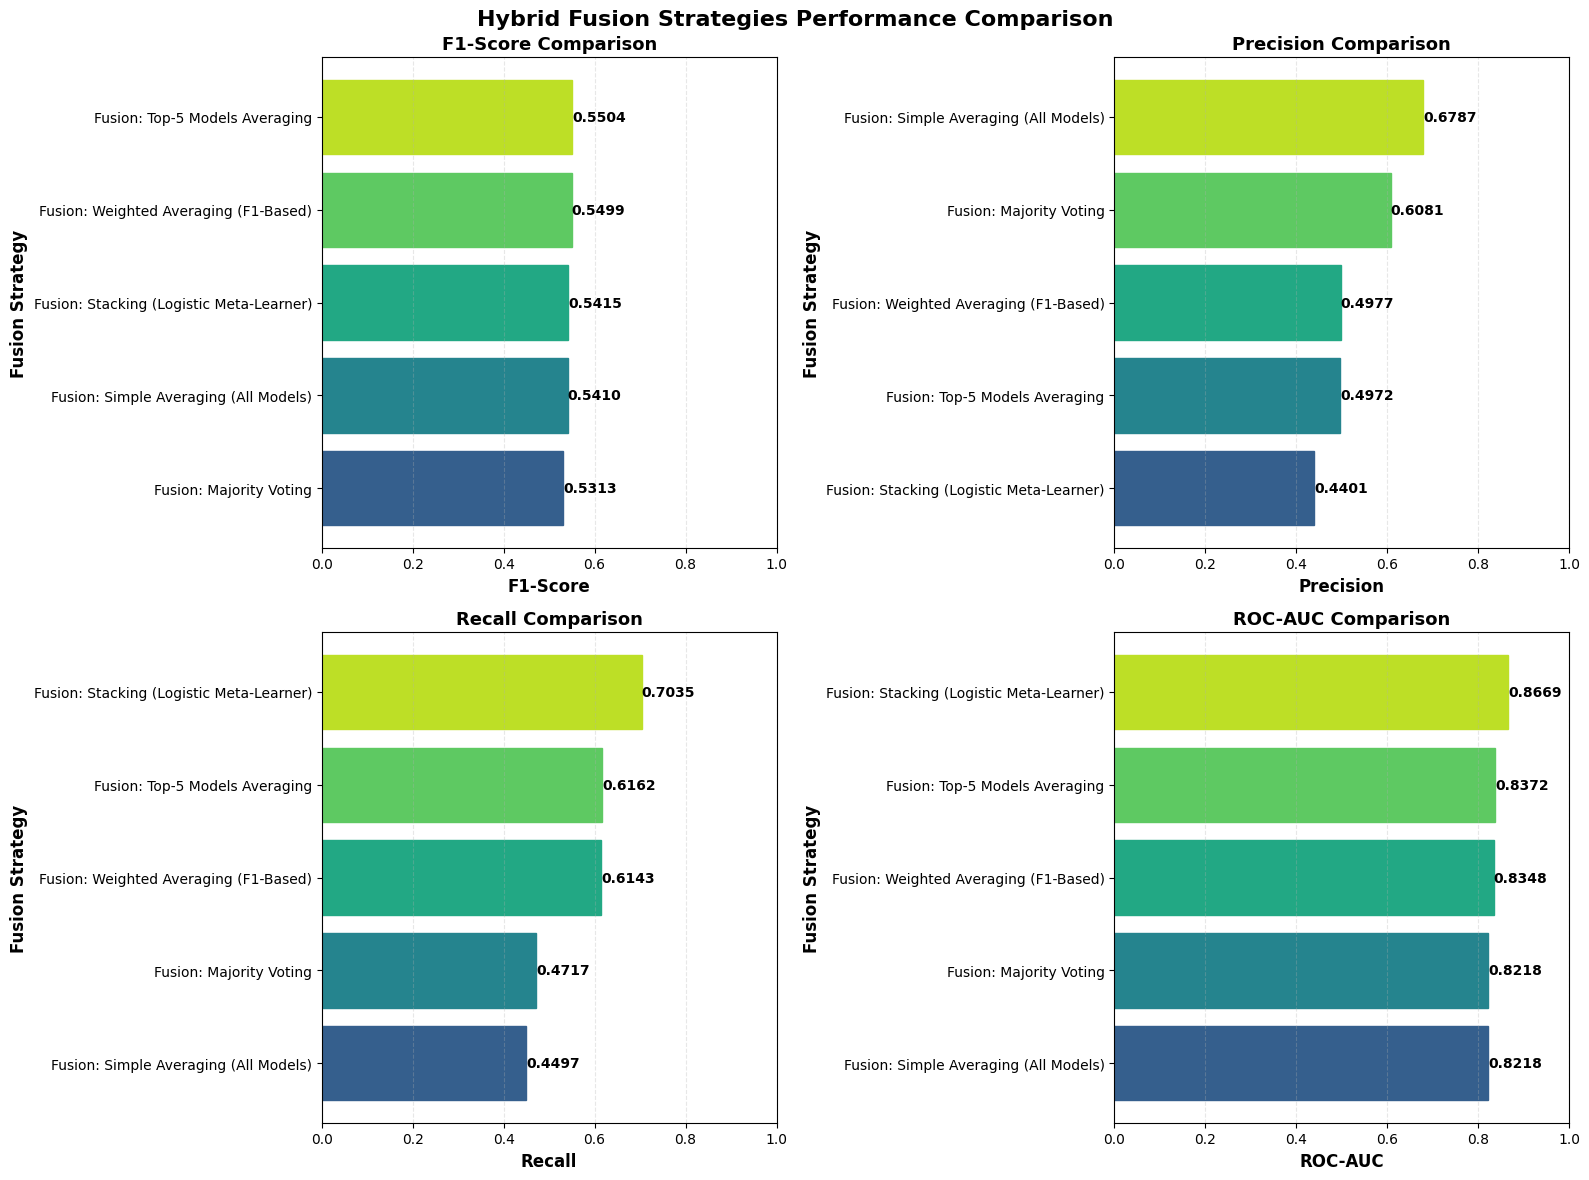

In [ ]:
print("\nCreating fusion comparison visualizations...")

# Create comparison chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hybrid Fusion Strategies Performance Comparison', fontsize=16, fontweight='bold')

metrics_to_plot = ['f1_score', 'precision', 'recall', 'roc_auc']
titles = ['F1-Score', 'Precision', 'Recall', 'ROC-AUC']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]
 
    # Sort by metric
    sorted_df = fusion_df.sort_values(by=metric, ascending=True)
 
    # Create horizontal bar chart
    bars = ax.barh(sorted_df['model_name'], sorted_df[metric])
 
    # Color bars
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(bars)))
    for bar, color in zip(bars, colors):
    bar.set_color(color)
 
    # Add value labels
    for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, 
    f'{width:.4f}', 
    ha='left', va='center', fontweight='bold', fontsize=10)
 
    ax.set_xlabel(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('Fusion Strategy', fontsize=12, fontweight='bold')
    ax.set_title(f'{title} Comparison', fontsize=13, fontweight='bold')
    ax.set_xlim(0, 1.0)
    ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('hybrid_fusion_comparison.png', dpi=300, bbox_inches='tight')
print("Chart saved: hybrid_fusion_comparison.png")
plt.show()

## 14. ROC and PR Curves - Fusion Strategies


Creating ROC and Precision-Recall curves...
ROC and PR curves saved: hybrid_fusion_roc_pr_curves.png


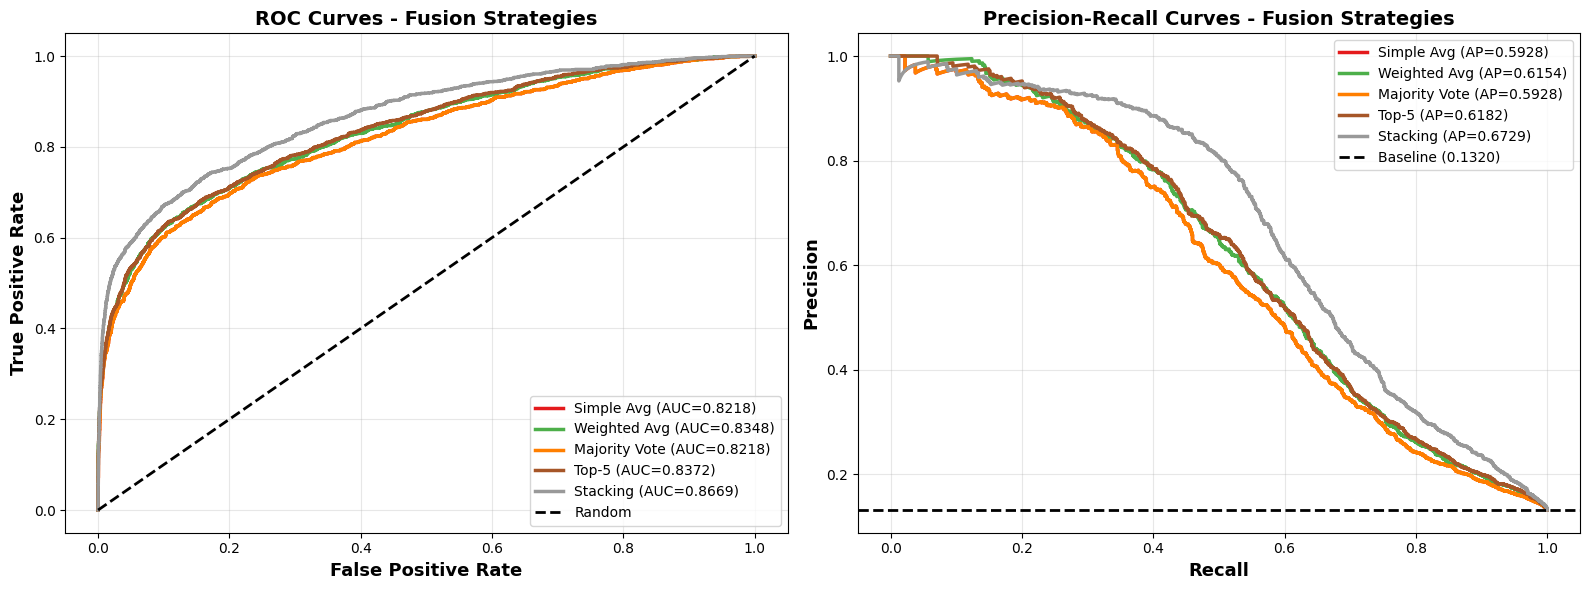

In [ ]:
print("\nCreating ROC and Precision-Recall curves...")

# Prepare fusion predictions
fusion_predictions = {
    'Simple Avg': avg_proba,
    'Weighted Avg': weighted_proba,
    'Majority Vote': voting_proba,
    f'Top-{K}': topk_proba,
    'Stacking': stacking_proba
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.Set1(np.linspace(0, 1, len(fusion_predictions)))

for (name, proba), color in zip(fusion_predictions.items(), colors):
    # ROC curve
    fpr, tpr, _ = roc_curve(y_val, proba)
    roc_auc = roc_auc_score(y_val, proba)
    ax1.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.4f})', color=color, linewidth=2.5)
 
    # PR curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, proba)
    pr_auc = average_precision_score(y_val, proba)
    ax2.plot(recall_curve, precision_curve, label=f'{name} (AP={pr_auc:.4f})', color=color, linewidth=2.5)

# ROC plot formatting
ax1.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=2)
ax1.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax1.set_title('ROC Curves - Fusion Strategies', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(alpha=0.3)

# PR plot formatting
fraud_ratio = np.sum(y_val) / len(y_val)
ax2.axhline(y=fraud_ratio, color='k', linestyle='--', label=f'Baseline ({fraud_ratio:.4f})', linewidth=2)
ax2.set_xlabel('Recall', fontsize=13, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax2.set_title('Precision-Recall Curves - Fusion Strategies', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('hybrid_fusion_roc_pr_curves.png', dpi=300, bbox_inches='tight')
print("ROC and PR curves saved: hybrid_fusion_roc_pr_curves.png")
plt.show()

---
## 15. Test Set Evaluation - Best Fusion Strategy

In [ ]:
print("\n" + "="*80)
print("FINAL TEST SET EVALUATION")
print("="*80)

# Get predictions on test set
ml_test_predictions = get_ml_predictions(ml_models, X_test, return_proba=True)
dl_test_predictions = get_dl_predictions(dl_models, X_test, return_proba=True)

all_test_predictions = {**ml_test_predictions, **dl_test_predictions}

# Apply best fusion strategy (Stacking)
print("\nApplying best fusion strategy to test set...")

# Create stacking features for test set
test_stacking_features = np.column_stack(list(all_test_predictions.values()))

# Get predictions from meta-learner
final_test_proba = meta_learner.predict_proba(test_stacking_features)[:, 1]
final_test_pred = meta_learner.predict(test_stacking_features)

# Evaluate on test set
final_test_metrics = evaluate_model(y_test, final_test_proba, final_test_pred, 
    "FINAL MODEL: Stacking Fusion (Test Set)")

print("\n" + "="*80)
print("TEST SET PERFORMANCE SUMMARY")
print("="*80)
print(f"\nModel: Hybrid ML+DL Stacking Ensemble")
print(f"Test Samples: {len(y_test):,}")
print(f"\nPerformance:")
print(f" F1-Score: {final_test_metrics['f1_score']:.4f}")
print(f" Precision: {final_test_metrics['precision']:.4f}")
print(f" Recall: {final_test_metrics['recall']:.4f}")
print(f" ROC-AUC: {final_test_metrics['roc_auc']:.4f}")
print(f" PR-AUC: {final_test_metrics['pr_auc']:.4f}")
print(f" Accuracy: {final_test_metrics['accuracy']:.4f}")
print(f" Specificity: {final_test_metrics['specificity']:.4f}")


FINAL TEST SET EVALUATION

Applying best fusion strategy to test set...

EVALUATING: FINAL MODEL: Stacking Fusion (Test Set)

Performance Metrics:
 Accuracy: 0.8433
 Precision: 0.4420
 Recall: 0.7125
 F1-Score: 0.5455
 ROC-AUC: 0.8691
 PR-AUC: 0.6746
 Specificity: 0.8631

Confusion Matrix:
 TN: 9,038 | FP: 1,433
 FN: 458 | TP: 1,135

TEST SET PERFORMANCE SUMMARY

Model: Hybrid ML+DL Stacking Ensemble
Test Samples: 12,064

Performance:
 F1-Score: 0.5455
 Precision: 0.4420
 Recall: 0.7125
 ROC-AUC: 0.8691
 PR-AUC: 0.6746
 Accuracy: 0.8433
 Specificity: 0.8631


---
## 15.1 Save Base Model Predictions for Meta-Learner

In [ ]:
print("\n" + "="*80)
print("SAVING BASE MODEL PREDICTIONS")
print("="*80)

# Create predictions directory
os.makedirs('predictions', exist_ok=True)

# Validation set predictions
print("\n1. Validation Set Predictions:")
print("-" * 40)

# ML predictions (validation)
ml_val_predictions = np.column_stack([
    ml_predictions_proba['Logistic Regression'],
    ml_predictions_proba['Random Forest'],
    ml_predictions_proba['XGBoost'],
    ml_predictions_proba['XGBoost SMOTE'],
    ml_predictions_proba['CatBoost']
])
print(f"ML predictions shape: {ml_val_predictions.shape}")
np.save('predictions/p_ml_val.npy', ml_val_predictions)
print(" Saved: predictions/p_ml_val.npy")

# DL predictions (validation)
dl_val_predictions = np.column_stack([
    dl_predictions_proba['FNN'],
    dl_predictions_proba['CNN'],
    dl_predictions_proba['LSTM'],
    dl_predictions_proba['BiLSTM'],
    dl_predictions_proba['CNN-BiLSTM']
])
print(f"DL predictions shape: {dl_val_predictions.shape}")
np.save('predictions/p_dl_val.npy', dl_val_predictions)
print(" Saved: predictions/p_dl_val.npy")

# Combined predictions (validation)
all_val_predictions = np.column_stack([ml_val_predictions, dl_val_predictions])
print(f"Combined predictions shape: {all_val_predictions.shape}")
np.save('predictions/p_all_val.npy', all_val_predictions)
print(" Saved: predictions/p_all_val.npy")

# Test set predictions
print("\n2. Test Set Predictions:")
print("-" * 40)

# ML predictions (test)
ml_test_pred_array = np.column_stack([
    ml_test_predictions['Logistic Regression'],
    ml_test_predictions['Random Forest'],
    ml_test_predictions['XGBoost'],
    ml_test_predictions['XGBoost SMOTE'],
    ml_test_predictions['CatBoost']
])
print(f"ML predictions shape: {ml_test_pred_array.shape}")
np.save('predictions/p_ml_test.npy', ml_test_pred_array)
print(" Saved: predictions/p_ml_test.npy")

# DL predictions (test)
dl_test_pred_array = np.column_stack([
    dl_test_predictions['FNN'],
    dl_test_predictions['CNN'],
    dl_test_predictions['LSTM'],
    dl_test_predictions['BiLSTM'],
    dl_test_predictions['CNN-BiLSTM']
])
print(f"DL predictions shape: {dl_test_pred_array.shape}")
np.save('predictions/p_dl_test.npy', dl_test_pred_array)
print(" Saved: predictions/p_dl_test.npy")

# Combined predictions (test)
all_test_pred_array = np.column_stack([ml_test_pred_array, dl_test_pred_array])
print(f"Combined predictions shape: {all_test_pred_array.shape}")
np.save('predictions/p_all_test.npy', all_test_pred_array)
print(" Saved: predictions/p_all_test.npy")

# Save model names for reference
model_names = {
    'ml_models': list(ml_predictions_proba.keys()),
    'dl_models': list(dl_predictions_proba.keys()),
    'all_models': list(ml_predictions_proba.keys()) + list(dl_predictions_proba.keys())
}

with open('predictions/model_names.json', 'w') as f:
    json.dump(model_names, f, indent=2)
print("\n Saved: predictions/model_names.json")

print("\n" + "="*80)
print(f"PREDICTIONS SAVED SUCCESSFULLY")
print("="*80)
print(f"\nSummary:")
print(f" ML models: {ml_val_predictions.shape[1]}")
print(f" DL models: {dl_val_predictions.shape[1]}")
print(f" Total base models: {all_val_predictions.shape[1]}")
print(f" Validation samples: {ml_val_predictions.shape[0]:,}")
print(f" Test samples: {ml_test_pred_array.shape[0]:,}")

## 15.2 Threshold Optimization for Best Fusion Model

In [ ]:
print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION - STACKING FUSION")
print("="*80)

def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    """
    Find optimal threshold to maximize specified metric
    """
    thresholds = np.arange(0.1, 0.9, 0.01)
    scores = []
 
    for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    if metric == 'f1':
    score = f1_score(y_true, y_pred, zero_division=0)
    elif metric == 'precision':
    score = precision_score(y_true, y_pred, zero_division=0)
    elif metric == 'recall':
    score = recall_score(y_true, y_pred, zero_division=0)
    scores.append(score)
 
    best_idx = np.argmax(scores)
    best_threshold = thresholds[best_idx]
    best_score = scores[best_idx]
 
    return best_threshold, best_score, thresholds, scores

# Find optimal threshold for stacking model
print("\nOptimizing threshold for Stacking Fusion model...")
best_threshold, best_f1, thresholds, f1_scores = find_optimal_threshold(
    y_val, 
    stacking_proba, 
    metric='f1'
)

print(f"\n Optimal Threshold: {best_threshold:.3f}")
print(f" F1-Score at optimal threshold: {best_f1:.4f}")
print(f" F1-Score at default (0.5): {f1_score(y_val, (stacking_proba >= 0.5).astype(int)):.4f}")
print(f" Improvement: {((best_f1 / f1_score(y_val, (stacking_proba >= 0.5).astype(int)) - 1) * 100):.2f}%")

# Evaluate with optimal threshold
optimized_pred = (stacking_proba >= best_threshold).astype(int)
optimized_metrics = evaluate_model(y_val, stacking_proba, optimized_pred, 
    f"Stacking Fusion (Optimized Threshold={best_threshold:.3f})")

# Plot threshold optimization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# F1-Score vs Threshold
ax1.plot(thresholds, f1_scores, 'b-', linewidth=2.5, label='F1-Score')
ax1.axvline(best_threshold, color='r', linestyle='--', linewidth=2, label=f'Optimal = {best_threshold:.3f}')
ax1.axvline(0.5, color='g', linestyle='--', linewidth=2, label='Default = 0.5')
ax1.scatter([best_threshold], [best_f1], color='r', s=200, zorder=5, marker='*', 
    edgecolors='black', linewidths=2, label=f'Max F1 = {best_f1:.4f}')
ax1.set_xlabel('Threshold', fontsize=13, fontweight='bold')
ax1.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax1.set_title('F1-Score vs Decision Threshold', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(alpha=0.3)

# Precision-Recall tradeoff
precisions = []
recalls = []
for threshold in thresholds:
    y_pred = (stacking_proba >= threshold).astype(int)
    precisions.append(precision_score(y_val, y_pred, zero_division=0))
    recalls.append(recall_score(y_val, y_pred, zero_division=0))

ax2.plot(thresholds, precisions, 'b-', linewidth=2.5, label='Precision')
ax2.plot(thresholds, recalls, 'g-', linewidth=2.5, label='Recall')
ax2.plot(thresholds, f1_scores, 'r-', linewidth=2.5, label='F1-Score')
ax2.axvline(best_threshold, color='black', linestyle='--', linewidth=2, 
    label=f'Optimal = {best_threshold:.3f}')
ax2.set_xlabel('Threshold', fontsize=13, fontweight='bold')
ax2.set_ylabel('Score', fontsize=13, fontweight='bold')
ax2.set_title('Precision-Recall-F1 Tradeoff', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=300, bbox_inches='tight')
print("\n Saved: threshold_optimization.png")
plt.show()

# Save optimal threshold
with open('saved_models/optimal_threshold.json', 'w') as f:
    json.dump({
    'optimal_threshold': float(best_threshold),
    'f1_score_optimal': float(best_f1),
    'f1_score_default': float(f1_score(y_val, (stacking_proba >= 0.5).astype(int))),
    'improvement_percent': float((best_f1 / f1_score(y_val, (stacking_proba >= 0.5).astype(int)) - 1) * 100)
    }, f, indent=2)
print(" Saved: saved_models/optimal_threshold.json")

## 16. Save Final Hybrid Model and Results

In [ ]:
print("\n" + "="*80)
print("SAVING FINAL HYBRID MODEL AND RESULTS")
print("="*80)

# Create output directories
os.makedirs('saved_models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Save meta-learner
print("\nSaving meta-learner...")
with open('saved_models/hybrid_meta_learner.pkl', 'wb') as f:
    pickle.dump(meta_learner, f)
print(" Saved: hybrid_meta_learner.pkl")

# Save fusion comparison results
print("\nSaving comparison results...")
fusion_df.to_csv('results/fusion_strategies_comparison.csv', index=False)
print(" Saved: fusion_strategies_comparison.csv")

# Save all metrics
all_metrics = {
    'baseline_models': baseline_metrics,
    'fusion_strategies': fusion_metrics,
    'test_set_final': final_test_metrics,
    'best_fusion_strategy': best_fusion['model_name'],
    'total_models_used': len(all_predictions_proba)
}

with open('results/hybrid_fusion_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=2)
print(" Saved: hybrid_fusion_metrics.json")

# Save model list
model_info = {
    'ml_models': list(ml_models.keys()),
    'dl_models': list(dl_models.keys()),
    'total_base_models': len(all_predictions_proba),
    'meta_learner': 'Logistic Regression',
    'fusion_strategy': 'Stacking Ensemble',
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('results/hybrid_model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print(" Saved: hybrid_model_info.json")

print("\n" + "="*80)
print("ALL FILES SAVED SUCCESSFULLY")
print("="*80)

## 17. Final Summary

In [ ]:
print("\n" + "="*80)
print("HYBRID ML+DL FUSION ENSEMBLE - FINAL SUMMARY")
print("="*80)

summary = f"""

    FRAUD DETECTION HYBRID ENSEMBLE 
╝

BASE MODELS:
    Machine Learning Models: {len(ml_models)}
    {', '.join(ml_models.keys())}
 
    Deep Learning Models: {len(dl_models)}
    {', '.join(dl_models.keys())}
 
    Total Base Models: {len(all_predictions_proba)}

FUSION STRATEGIES TESTED: 5
    1. Simple Averaging
    2. Weighted Averaging (F1-based)
    3. Majority Voting
    4. Top-{K} Models
    5. Stacking (Meta-Learner)

BEST STRATEGY: {best_fusion['model_name']}

VALIDATION SET PERFORMANCE:
    F1-Score: {best_fusion['f1_score']:.4f}
    Precision: {best_fusion['precision']:.4f}
    Recall: {best_fusion['recall']:.4f}
    ROC-AUC: {best_fusion['roc_auc']:.4f}
    PR-AUC: {best_fusion['pr_auc']:.4f}

TEST SET PERFORMANCE:
    F1-Score: {final_test_metrics['f1_score']:.4f}
    Precision: {final_test_metrics['precision']:.4f}
    Recall: {final_test_metrics['recall']:.4f}
    ROC-AUC: {final_test_metrics['roc_auc']:.4f}
    PR-AUC: {final_test_metrics['pr_auc']:.4f}
    Accuracy: {final_test_metrics['accuracy']:.4f}
    Specificity: {final_test_metrics['specificity']:.4f}

CONFUSION MATRIX (Test Set):
    True Negatives: {final_test_metrics['tn']:,}
    False Positives: {final_test_metrics['fp']:,}
    False Negatives: {final_test_metrics['fn']:,}
    True Positives: {final_test_metrics['tp']:,}

FILES CREATED:
    • saved_models/hybrid_meta_learner.pkl
    • results/fusion_strategies_comparison.csv
    • results/hybrid_fusion_metrics.json
    • results/hybrid_model_info.json
    • hybrid_fusion_comparison.png
    • hybrid_fusion_roc_pr_curves.png

DEPLOYMENT READY: 

Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

"""

print(summary)

# Save summary
with open('results/hybrid_fusion_summary.txt', 'w') as f:
    f.write(summary)

print("\n Summary saved: results/hybrid_fusion_summary.txt")
print("\n" + "="*80)
print("HYBRID FUSION ENSEMBLE COMPLETE!")
print("="*80)